In [1]:
import pandas as pd
import json
from itertools import chain
import networkx as nx

In [2]:
prettyprint = lambda x: json.dumps(x, indent=4, sort_keys=True)

### Exploring the data first

In [5]:
#This assumes you have all_plans_with_wires.json in the same folder as the notebook.
with open('all_plans_with_wires.json', 'r') as f:
    aq_plans_json = json.load(f)

In [6]:
print(len(aq_plans_json)) #9616
print(prettyprint(aq_plans_json[3]))

9616
{
    "created_at": "2017-07-13T09:01:17.000-07:00",
    "id": 15,
    "operations": [
        {
            "created_at": "2017-07-13T09:01:17.000-07:00",
            "field_values": [
                {
                    "rid": 19675,
                    "role": "input",
                    "sample": {
                        "rid": 19679,
                        "sample_type_id": 2
                    },
                    "sample_type": 2
                },
                {
                    "rid": 19676,
                    "role": "output",
                    "sample": {
                        "rid": 19681,
                        "sample_type_id": 2
                    },
                    "sample_type": 2
                },
                {
                    "rid": 19677,
                    "role": "output",
                    "sample": {
                        "rid": 19683,
                        "sample_type_id": 2
                    },
                 

In [7]:
from pandas.io.json import json_normalize
operations_df = json_normalize(aq_plans_json, 
                       record_path=['operations', 'field_values'], 
                       meta=['id', 'created_at', 'updated_at', 'status', 'user_id',
                            ['op', 'id'], ['op', 'operation_type_id'], ['op', 'created_at'], ['op', 'updated_at'], ['op', 'status'], ['op', 'operation_type']],
                       record_prefix='fv.')

In [8]:
operations_df = operations_df.drop(columns=['fv.sample', 'fv.rid']) # drop irrelevant columns
operations_df = operations_df.rename(index=str, columns={"op.operation_type": "op.category"}) #rename for clarity
print(operations_df['id'].nunique())
operations_df.head(5)

8819


,fv.role,fv.sample_type,id,created_at,updated_at,status,user_id,op.id,op.operation_type_id,op.created_at,op.updated_at,op.status,op.category
0,output,2.0,9,2017-07-13T08:29:06.000-07:00,2018-07-27T08:39:35.000-07:00,None,66,17,48,2017-07-13T08:29:06.000-07:00,2017-07-13T08:50:43.000-07:00,done,Cloning
1,output,2.0,10,2017-07-13T08:29:06.000-07:00,2018-07-27T08:39:35.000-07:00,None,66,18,48,2017-07-13T08:29:06.000-07:00,2017-07-13T08:50:43.000-07:00,done,Cloning
2,input,2.0,13,2017-07-13T08:58:15.000-07:00,2017-07-13T08:58:16.000-07:00,None,17,27,20,2017-07-13T08:58:15.000-07:00,2017-07-13T09:17:41.000-07:00,error,Cloning
3,output,2.0,13,2017-07-13T08:58:15.000-07:00,2017-07-13T08:58:16.000-07:00,None,17,27,20,2017-07-13T08:58:15.000-07:00,2017-07-13T09:17:41.000-07:00,error,Cloning
4,output,2.0,13,2017-07-13T08:58:15.000-07:00,2017-07-13T08:58:16.000-07:00,None,17,27,20,2017-07-13T08:58:15.000-07:00,2017-07-13T09:17:41.000-07:00,error,Cloning


In [9]:
operations_df.shape

(284678, 13)

### Let's try grouping plans through their id and finding their unique operations. Then make a dedicted data structure for it.

In [11]:
ops_list = operations_df.groupby('id')['op.operation_type_id'].unique()


In [12]:
ops_list

id
9                                                     [48]
10                                                    [48]
13                                [20, 19, 18, 30, 29, 28]
15                                [20, 19, 18, 30, 29, 28]
17                                [20, 19, 18, 30, 29, 28]
18                                [20, 19, 18, 30, 29, 28]
20                                [20, 19, 18, 30, 29, 28]
27                                [20, 19, 18, 30, 29, 28]
29                                [20, 19, 18, 30, 29, 28]
31                                [20, 19, 18, 30, 29, 28]
33                                [20, 19, 18, 30, 29, 28]
38                        [20, 19, 18, 30, 29, 28, 21, 22]
39                        [20, 19, 18, 30, 29, 28, 21, 22]
40                                            [19, 18, 30]
42                            [20, 19, 18, 30, 29, 28, 22]
44                            [20, 19, 18, 30, 29, 28, 22]
46                                        [20, 19, 18

In [13]:
df_plan_ops = ops_list.to_frame()
df_plan_ops = df_plan_ops.reset_index()
df_plan_ops.head(10)

,id,op.operation_type_id
0,9,[48]
1,10,[48]
2,13,"[20, 19, 18, 30, 29, 28]"
3,15,"[20, 19, 18, 30, 29, 28]"
4,17,"[20, 19, 18, 30, 29, 28]"
5,18,"[20, 19, 18, 30, 29, 28]"
6,20,"[20, 19, 18, 30, 29, 28]"
7,27,"[20, 19, 18, 30, 29, 28]"
8,29,"[20, 19, 18, 30, 29, 28]"
9,31,"[20, 19, 18, 30, 29, 28]"


### Connected Components Approach

In [14]:
df_plan_ops.head()


,id,op.operation_type_id
0,9,[48]
1,10,[48]
2,13,"[20, 19, 18, 30, 29, 28]"
3,15,"[20, 19, 18, 30, 29, 28]"
4,17,"[20, 19, 18, 30, 29, 28]"


### Below, we get a unique list of nodes and add the nodes to a networkx graph

In [21]:
G = nx.Graph()   
nodes = df_plan_ops['op.operation_type_id']
result = set(chain(*nodes))
print(len(result))
G.add_nodes_from(result)

316


### Two nodes (operations) in the above graph will share an edge if they occur together in any plan. Below, we add unique edge to our graoh

In [22]:
from itertools import combinations 
    
plan_edge_df = pd.DataFrame(columns=['source', 'target'])
unique_edges = []
for index, row in df_plan_ops.iterrows():
    operations = row['op.operation_type_id']
    # print(len(operations))
    #if node length is one, skip it because it is unconnected.
    #Else for each pair in the list add an edge if it doesn't aready exist in the edge list
    if(len(operations) > 1):        
        operation_pairs = list(combinations(operations, 2))
        for pair in operation_pairs:
            if pair not in unique_edges:
                unique_edges.append(pair)
                
unique_edges

[(20, 19),
 (20, 18),
 (20, 30),
 (20, 29),
 (20, 28),
 (19, 18),
 (19, 30),
 (19, 29),
 (19, 28),
 (18, 30),
 (18, 29),
 (18, 28),
 (30, 29),
 (30, 28),
 (29, 28),
 (20, 21),
 (20, 22),
 (19, 21),
 (19, 22),
 (18, 21),
 (18, 22),
 (30, 21),
 (30, 22),
 (29, 21),
 (29, 22),
 (28, 21),
 (28, 22),
 (21, 22),
 (25, 24),
 (25, 16),
 (25, 15),
 (25, 17),
 (25, 23),
 (24, 16),
 (24, 15),
 (24, 17),
 (24, 23),
 (16, 15),
 (16, 17),
 (16, 23),
 (15, 17),
 (15, 23),
 (17, 23),
 (20, 27),
 (20, 26),
 (20, 25),
 (20, 24),
 (20, 16),
 (20, 15),
 (20, 17),
 (20, 23),
 (19, 27),
 (19, 26),
 (19, 25),
 (19, 24),
 (19, 16),
 (19, 15),
 (19, 17),
 (19, 23),
 (18, 27),
 (18, 26),
 (18, 25),
 (18, 24),
 (18, 16),
 (18, 15),
 (18, 17),
 (18, 23),
 (30, 27),
 (30, 26),
 (30, 25),
 (30, 24),
 (30, 16),
 (30, 15),
 (30, 17),
 (30, 23),
 (29, 27),
 (29, 26),
 (29, 25),
 (29, 24),
 (29, 16),
 (29, 15),
 (29, 17),
 (29, 23),
 (28, 27),
 (28, 26),
 (28, 25),
 (28, 24),
 (28, 16),
 (28, 15),
 (28, 17),
 (28, 23),

In [23]:
G.add_edges_from(unique_edges)

In [24]:
nodes_on_one_end_of_edge = set(chain(*unique_edges))
len(nodes_on_one_end_of_edge)

287

### Now, find the connected components in our graph. The connected components would not be connected amongst each other, which can serve as a basis for getting the disjoint subsets.

In [25]:
len(sorted(nx.connected_components(G)))

38

In [26]:
#Biggest group is 256 plans
largest_cc = max(nx.connected_components(G), key=len)
len(largest_cc)

256

### Considering each connected component as a group, we now add group membership to each plan based on which connected component it's operations lie in.

In [27]:
def get_component_membership(op):
    comp_index = -1
    for idx, c in enumerate(sorted(nx.connected_components(G), key=len, reverse=True)):
        if op in c:
            comp_index = idx 
    return comp_index
        
def add_group_id(row):
    #check which connected component that plan belongs to. Use the first operation.
    return get_component_membership(row['op.operation_type_id'][0])


In [28]:
df_plan_ops['groupid'] = df_plan_ops.apply(add_group_id, axis=1)
df_plan_ops.head()
    

,id,op.operation_type_id,groupid
0,9,[48],9
1,10,[48],9
2,13,"[20, 19, 18, 30, 29, 28]",0
3,15,"[20, 19, 18, 30, 29, 28]",0
4,17,"[20, 19, 18, 30, 29, 28]",0


In [29]:
df_plan_ops['groupid'].value_counts(normalize=True)

0     0.955891
11    0.008958
5     0.007144
2     0.006803
21    0.005896
1     0.002268
26    0.001701
19    0.001587
12    0.001474
17    0.001247
14    0.000907
15    0.000794
3     0.000794
8     0.000454
9     0.000340
22    0.000340
13    0.000227
28    0.000227
4     0.000227
25    0.000227
32    0.000227
33    0.000227
37    0.000227
18    0.000227
16    0.000113
24    0.000113
31    0.000113
10    0.000113
34    0.000113
23    0.000113
35    0.000113
20    0.000113
36    0.000113
29    0.000113
6     0.000113
30    0.000113
7     0.000113
27    0.000113
Name: groupid, dtype: float64

### Try min cut on the biggest connected component. This did not work really well because min cut kept splitting individual nodes above.

In [30]:
list_of_component_sets = sorted(nx.connected_components(G), key=len, reverse=True)
biggest_component_nodes = list(list_of_component_sets[0])
len(biggest_component_nodes)
H = G.subgraph(biggest_component_nodes)
H.edges()

EdgeView([(15, 25), (15, 24), (15, 16), (15, 17), (15, 23), (15, 20), (15, 19), (15, 18), (15, 30), (15, 29), (15, 28), (15, 27), (15, 26), (15, 31), (15, 22), (15, 21), (15, 50), (15, 84), (15, 83), (15, 82), (15, 88), (15, 87), (15, 89), (15, 214), (15, 213), (15, 215), (15, 63), (15, 47), (15, 221), (15, 220), (15, 198), (15, 199), (15, 534), (15, 174), (15, 172), (15, 185), (15, 170), (15, 169), (15, 176), (15, 167), (15, 175), (15, 43), (15, 41), (15, 37), (15, 42), (15, 38), (15, 39), (15, 40), (15, 49), (15, 45), (15, 277), (15, 271), (15, 403), (15, 200), (15, 454), (15, 455), (15, 90), (15, 266), (15, 262), (15, 267), (15, 275), (15, 270), (15, 269), (15, 274), (15, 264), (15, 265), (15, 272), (15, 258), (15, 259), (15, 466), (15, 468), (15, 406), (15, 494), (15, 496), (15, 493), (15, 56), (15, 57), (15, 58), (15, 499), (15, 500), (15, 453), (15, 276), (15, 449), (15, 450), (15, 452), (15, 518), (15, 495), (15, 545), (15, 529), (15, 329), (15, 86), (15, 78), (15, 399), (15, 40

In [25]:
edge_to_remove = nx.minimum_edge_cut(H)
edge_to_remove

{(90, 344)}

In [31]:
unfreezed_graph = nx.Graph(H)
unfreezed_graph.remove_edge(90,344)
nx.is_connected(unfreezed_graph)

False

In [32]:
# max_component = max(nx.connected_components(unfreezed_graph), key=len)
# len(max_component)
[len(c) for c in sorted(nx.connected_components(unfreezed_graph), key=len, reverse=True)]


[255, 1]

### We can see this isn't very successful because min cut is removing one edge in a minimal fashion

### Let's try to visualize the graph

/Users/shreya/anaconda3/envs/asl/lib/python3.7/site-packages/networkx-2.3-py3.7.egg/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


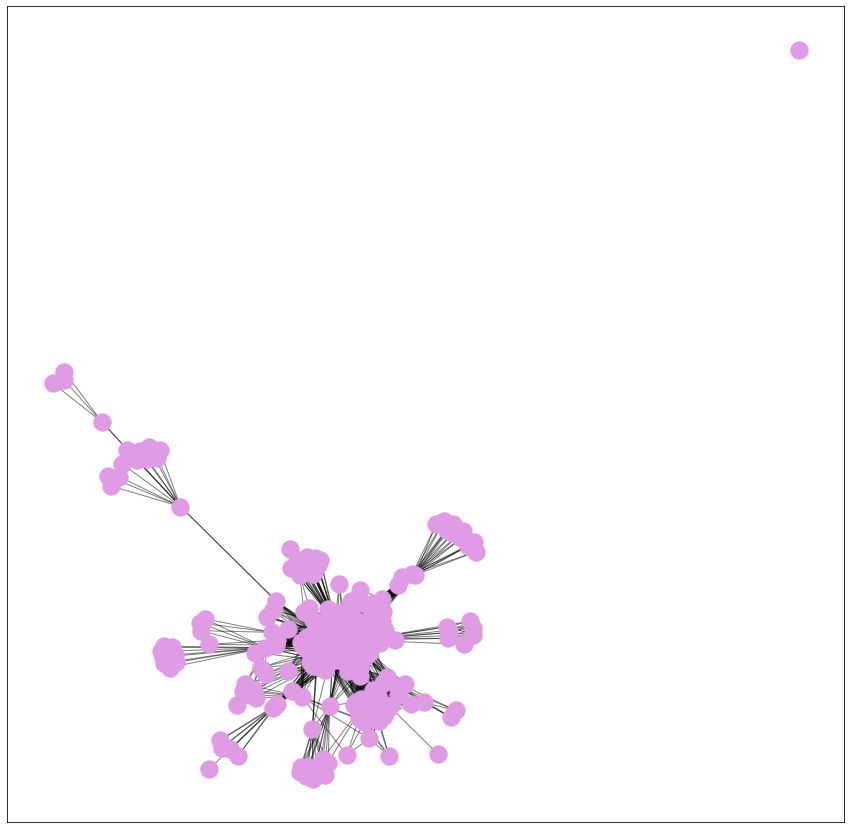

In [35]:
import matplotlib.pyplot as plt
import randomcolor

%matplotlib inline 
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)

pos = nx.spring_layout(unfreezed_graph)
nx.draw_networkx_nodes(unfreezed_graph, pos, unfreezed_graph.nodes(),
                                node_color = randomcolor.RandomColor().generate()[0])



nx.draw_networkx_edges(unfreezed_graph, pos, alpha=0.5)


## Lets try to delete highly connected nodes and see

In [36]:
def break_down_futher(temp_graph):
    for node in temp_graph:
        #make fresh copy of the graph
        G_temp = nx.Graph(temp_graph)
        #remove node from graph
        G_temp.remove_node(node)
        components= sorted(nx.connected_components(G_temp), key=len, reverse=True)
        #Now find connected components and print length of each
        print("The node and components are....")
        print(node)
        print([len(c) for c in components])


In [37]:
break_down_futher(unfreezed_graph)

The node and components are....
15
[254, 1]
The node and components are....
16
[254, 1]
The node and components are....
17
[254, 1]
The node and components are....
18
[254, 1]
The node and components are....
19
[254, 1]
The node and components are....
20
[254, 1]
The node and components are....
21
[254, 1]
The node and components are....
22
[254, 1]
The node and components are....
23
[254, 1]
The node and components are....
24
[254, 1]
The node and components are....
25
[254, 1]
The node and components are....
26
[254, 1]
The node and components are....
27
[254, 1]
The node and components are....
28
[254, 1]
The node and components are....
29
[254, 1]
The node and components are....
30
[254, 1]
The node and components are....
31
[254, 1]
The node and components are....
33
[254, 1]
The node and components are....
34
[254, 1]
The node and components are....
35
[254, 1]
The node and components are....
37
[254, 1]
The node and components are....
38
[254, 1]
The node and components are....


The node and components are....
477
[254, 1]
The node and components are....
481
[254, 1]
The node and components are....
482
[254, 1]
The node and components are....
483
[254, 1]
The node and components are....
484
[254, 1]
The node and components are....
490
[254, 1]
The node and components are....
493
[254, 1]
The node and components are....
494
[254, 1]
The node and components are....
495
[254, 1]
The node and components are....
496
[254, 1]
The node and components are....
499
[254, 1]
The node and components are....
500
[254, 1]
The node and components are....
503
[254, 1]
The node and components are....
504
[254, 1]
The node and components are....
505
[254, 1]
The node and components are....
511
[254, 1]
The node and components are....
512
[254, 1]
The node and components are....
514
[254, 1]
The node and components are....
515
[254, 1]
The node and components are....
516
[254, 1]
The node and components are....
518
[254, 1]
The node and components are....
525
[254, 1]
The node a

### By manually eyeballing the results above, we can see that removing node 178 from the graoh results in a better connected component split.

In [38]:
#Get the 238 split
G_238 = unfreezed_graph
G_238.remove_node(178)

In [39]:
def get_component_percentage(component):
    df_temp = df_plan_ops
    count = 0
    for index, row in df_temp.iterrows():
        #Check if first op belong to this group, add to count
        if row['op.operation_type_id'][0] in component:
            count+=1
    #return a percentage of plans
    return count/8819


In [40]:
df_temp = df_plan_ops
df_temp.shape
components_238= sorted(nx.connected_components(G_238), key=len, reverse=True)
for component in components_238:
    print(get_component_percentage(component))

0.9001020523868919
0.016214990361719014
0.0036285293117133462
0.0035151377707223043


## We have a group with 90% of plans as seen above! We can choose this to be one group and all other plans can be the other group (10%). Does splitting it further help?

In [39]:
# Further break down the 238 component
biggest_component_238 = list(components_238[0])
len(biggest_component_238)
sub_238 = G.subgraph(biggest_component_238)
sub_238.edges()


EdgeView([(15, 25), (15, 24), (15, 16), (15, 17), (15, 23), (15, 20), (15, 19), (15, 18), (15, 30), (15, 29), (15, 28), (15, 27), (15, 26), (15, 31), (15, 22), (15, 21), (15, 50), (15, 84), (15, 83), (15, 82), (15, 88), (15, 87), (15, 89), (15, 214), (15, 213), (15, 215), (15, 63), (15, 47), (15, 221), (15, 220), (15, 198), (15, 199), (15, 534), (15, 174), (15, 172), (15, 185), (15, 170), (15, 169), (15, 176), (15, 167), (15, 175), (15, 43), (15, 41), (15, 37), (15, 42), (15, 38), (15, 39), (15, 40), (15, 49), (15, 45), (15, 277), (15, 271), (15, 403), (15, 200), (15, 454), (15, 455), (15, 90), (15, 266), (15, 262), (15, 267), (15, 275), (15, 270), (15, 269), (15, 274), (15, 264), (15, 265), (15, 272), (15, 258), (15, 259), (15, 466), (15, 468), (15, 406), (15, 494), (15, 496), (15, 493), (15, 56), (15, 57), (15, 58), (15, 499), (15, 500), (15, 453), (15, 276), (15, 449), (15, 450), (15, 452), (15, 518), (15, 495), (15, 545), (15, 529), (15, 329), (15, 86), (15, 78), (15, 399), (15, 40

In [40]:
break_down_futher(sub_238)


The node and components are....
15
[238]
The node and components are....
16
[238]
The node and components are....
17
[238]
The node and components are....
18
[238]
The node and components are....
19
[238]
The node and components are....
20
[238]
The node and components are....
21
[238]
The node and components are....
22
[238]
The node and components are....
23
[238]
The node and components are....
24
[238]
The node and components are....
25
[238]
The node and components are....
26
[238]
The node and components are....
27
[238]
The node and components are....
28
[238]
The node and components are....
29
[238]
The node and components are....
30
[238]
The node and components are....
31
[238]
The node and components are....
33
[238]
The node and components are....
34
[238]
The node and components are....
35
[238]
The node and components are....
37
[238]
The node and components are....
38
[238]
The node and components are....
39
[238]
The node and components are....
40
[238]
The node and com

The node and components are....
536
[238]
The node and components are....
537
[238]
The node and components are....
538
[238]
The node and components are....
539
[238]
The node and components are....
540
[238]
The node and components are....
542
[238]
The node and components are....
544
[238]
The node and components are....
545
[238]
The node and components are....
546
[238]
The node and components are....
548
[238]
The node and components are....
562
[238]
The node and components are....
563
[238]
The node and components are....
581
[238]
The node and components are....
585
[238]
The node and components are....
586
[238]
The node and components are....
596
[238]
The node and components are....
597
[238]
The node and components are....
610
[238]
The node and components are....
611
[238]
The node and components are....
612
[238]
The node and components are....
613
[238]
The node and components are....
614
[238]
The node and components are....
615
[238]
The node and components are....
61

### We see that splitting it further doesn't help. Removing most nodes still gives us a single connected component that has 238 nodes. This means, that the nodes within this group are so highly connected, that removing most individual ones doesn't help, and the remaining graph still remains very well connected.

In [ ]:
##Dated algo below.

Algo:
declare an array of groups
Put first plan as its own group    
For each next plan, 
    get its unique elements. 
    for each group
        get unique members of that group, check if any of them matches the plan unique elements. Store that group id(s)
        if num_groups that it belongs to = 1, assign this plan to that group
        if num_groups that it belongs to > 1, merge those groups into 1, and assign this plan to the new group
        else create a new group object
        